![](https://user-images.githubusercontent.com/8117267/116876711-8defc300-ac25-11eb-8b7b-5eab8860602c.png)

# SMPLpix Dataset Preparation.

**Author**: [Sergey Prokudin](https://ps.is.mpg.de/people/sprokudin).
[[Project Page](https://sergeyprokudin.github.io/smplpix/)]
[[Paper](https://arxiv.org/pdf/2008.06872.pdf)]
[[Video](https://www.youtube.com/watch?v=JY9t4xUAouk)]
[[GitHub](https://github.com/sergeyprokudin/smplpix)]

This notebook contains an example workflow for converting a video file to a SMPLpix dataset.
### Processing steps:

1. Download the video of choice, extract frames;
2. Extract **2D keypoints**: run [OpenPose](https://github.com/CMU-Perceptual-Computing-Lab/openpose) on the extracted frames;
3. Infer **3D human meshes**: run [SMPLify-x](https://github.com/vchoutas/smplify-x) on the extracted frames + keypoints;
4. Form dataset **image pairs**, where *input* is SMPL-X mesh render, and *output* is the corresponding target ground truth video frame;
5. **Split the data** into train, test and validation, zip and copy to Google Drive.

### Instructions

1. Convert a video into our dataset format using this notebook.
2. Train a SMPLpix using the training notebook.


### Notes
* While this will work for small datasets in a Colab runtime, larger datasets will require more compute power;
* If you would like to train a model on a serious dataset, you should consider copying this to your own workstation and running it there. Some minor modifications will be required, and you will have to install the dependencies separately;
* Please report issues on the [GitHub issue tracker](https://github.com/sergeyprokudin/smplpix/issues).

If you find this work useful, please consider citing:
```bibtex
@inproceedings{prokudin2021smplpix,
  title={SMPLpix: Neural Avatars from 3D Human Models},
  author={Prokudin, Sergey and Black, Michael J and Romero, Javier},
  booktitle={Proceedings of the IEEE/CVF Winter Conference on Applications of Computer Vision},
  pages={1810--1819},
  year={2021}
}
```

Many thanks [Keunhong Park](https://keunhong.com) for providing the [Nerfie dataset preparation template](https://colab.research.google.com/github/google/nerfies/blob/main/notebooks/Nerfies_Capture_Processing.ipynb)!


## Upload the video and extract frames


In [1]:
# @title Upload your image
import os

RES_DIR = '/content/data'
FRAMES_DIR = os.path.join(RES_DIR, 'images')
!rm -rf $RES_DIR
!mkdir $RES_DIR
!mkdir $FRAMES_DIR

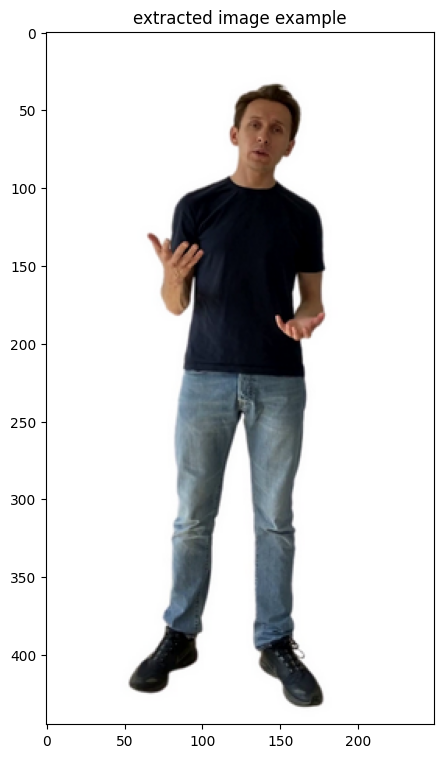

In [2]:
# @title Input your data in /content/data/images
filename =     "man.png"# @param {type:'string'}

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def load_img(img_path):

  return np.asarray(Image.open(img_path))/255

test_img_path = os.path.join(FRAMES_DIR, os.listdir(FRAMES_DIR)[0])

test_img = load_img(test_img_path)

plt.figure(figsize=(5, 10))
plt.title("extracted image example")
plt.imshow(test_img)

## Extract 2D body keypoints with OpenPose



In [3]:
############################################## (Important; manually (2024 8/30))
## Download openpose checkpoint three files
# (1) hand: https://www.kaggle.com/datasets/changethetuneman/openpose-model?select=pose_iter_102000.caffemodel
# (2) pose/body_25: https://www.kaggle.com/datasets/changethetuneman/openpose-model?select=pose_iter_584000.caffemodel
# (3) face: https://www.kaggle.com/datasets/changethetuneman/openpose-model?select=pose_iter_116000.caffemodel

# move below folders
%cd /content/
from google.colab import drive
drive.mount('/content/gdrive')

# move checkpoint below folders
!mkdir /content/gdrive/MyDrive/openpose
!mkdir /content/gdrive/MyDrive/openpose/hand # 102000.caffemodel
!mkdir /content/gdrive/MyDrive/openpose/pose # 584000.caffemodel
!mkdir /content/gdrive/MyDrive/openpose/face # 116000.caffemodel

/content
Mounted at /content/gdrive
mkdir: cannot create directory ‘/content/gdrive/MyDrive/openpose’: File exists
mkdir: cannot create directory ‘/content/gdrive/MyDrive/openpose/hand’: File exists
mkdir: cannot create directory ‘/content/gdrive/MyDrive/openpose/pose’: File exists
mkdir: cannot create directory ‘/content/gdrive/MyDrive/openpose/face’: File exists


In [6]:
# @title Install OpenPose
# @markdown This will take some time (~10 mins). The code is taken from this [OpenPose Colab notebook](https://colab.research.google.com/github/tugstugi/dl-colab-notebooks/blob/master/notebooks/OpenPose.ipynb).

%cd /content
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/AlecDusheck/openpose.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # see: https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/949
  # install new CMake becaue of CUDA10
  !wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
  !tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local

  # clone openpose
  !git clone -q --depth 1 $git_repo_url

  # download models (2024 ~8/29 not working)
  #!wget -O /content/openpose/models/hand/pose_iter_102000.caffemodel https://polybox.ethz.ch/index.php/s/Oim76cuqrDVbdxm/download
  #!wget -O /content/openpose/models/pose/body_25/pose_iter_584000.caffemodel https://polybox.ethz.ch/index.php/s/m5NQAhd7ukVPRoL/download
  #!wget -O /content/openpose/models/face/pose_iter_116000.caffemodel https://polybox.ethz.ch/index.php/s/cEaF1FTpKjjJZbH/download

  # (new 2024 8/30) download models
  %cd /content/

  HAND_ZIP_PATH = '/content/gdrive/MyDrive/openpose/hand/pose_iter_102000.caffemodel.zip' # @param {type:"string"}
  POSE_ZIP_PATH = '/content/gdrive/MyDrive/openpose/pose/pose_iter_584000.caffemodel.zip' # @param {type:"string"}
  FACE_ZIP_PATH = '/content/gdrive/MyDrive/openpose/face/pose_iter_116000.caffemodel.zip' # @param {type:"string"}

  HAND_MODEL_PATH = '/content/openpose/models/hand'
  #!mkdir $HAND_ZIP_PATH
  !unzip -n $HAND_ZIP_PATH -d $HAND_MODEL_PATH

  POSE_MODEL_PATH = '/content/openpose/models/pose/body_25'
  #!mkdir $POSE_ZIP_PATH
  !unzip -n $POSE_ZIP_PATH -d $POSE_MODEL_PATH

  FACE_MODEL_PATH = '/content/openpose/models/face'
  #!mkdir $FACE_ZIP_PATH
  !unzip -n $FACE_ZIP_PATH -d $FACE_MODEL_PATH
  !sed -i 's/execute_process(COMMAND git checkout master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt

  # install system dependencies
  !apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev

  # install python dependencies
  !pip install -q youtube-dl

  # build openpose
  !cd openpose && rm -rf build || true && mkdir build && cd build && cmake -DUSE_CUDNN=OFF .. && make -j`nproc`

/content
/content
Archive:  /content/gdrive/MyDrive/openpose/hand/pose_iter_102000.caffemodel.zip
  inflating: /content/openpose/models/hand/pose_iter_102000.caffemodel  
Archive:  /content/gdrive/MyDrive/openpose/pose/pose_iter_584000.caffemodel.zip
  inflating: /content/openpose/models/pose/body_25/pose_iter_584000.caffemodel  
Archive:  /content/gdrive/MyDrive/openpose/face/pose_iter_116000.caffemodel.zip
  inflating: /content/openpose/models/face/pose_iter_116000.caffemodel  
-- The C compiler identification is GNU 11.4.0
-- The CXX compiler identification is GNU 11.4.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info -

/content
mkdir: cannot create directory ‘/content/data/keypoints’: File exists
mkdir: cannot create directory ‘/content/data/openpose_images’: File exists
Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
OpenPose demo successfully finished. Total time: 2.763091 seconds.


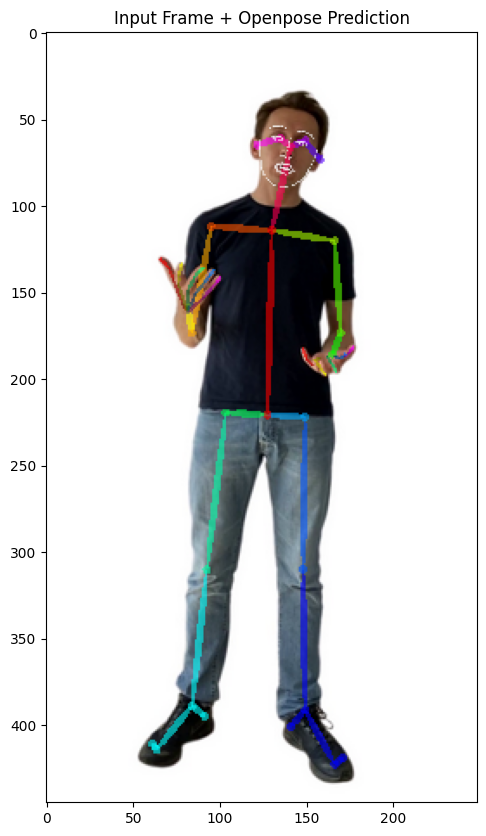

In [11]:
# @title Run OpenPose on the extracted frames
%cd /content
KEYPOINTS_DIR = os.path.join(RES_DIR, 'keypoints')
OPENPOSE_IMAGES_DIR = os.path.join(RES_DIR, 'openpose_images')
!mkdir $KEYPOINTS_DIR
!mkdir $OPENPOSE_IMAGES_DIR

!cd openpose && ./build/examples/openpose/openpose.bin --image_dir /content/data/images --write_json $KEYPOINTS_DIR --face --hand --display 0 --write_images $OPENPOSE_IMAGES_DIR

input_img_path = os.path.join(FRAMES_DIR, sorted(os.listdir(FRAMES_DIR))[0])
openpose_img_path = os.path.join(OPENPOSE_IMAGES_DIR, sorted(os.listdir(OPENPOSE_IMAGES_DIR))[0])

test_img = load_img(input_img_path)
open_pose_img = load_img(openpose_img_path)

plt.figure(figsize=(10, 10))
plt.title("Input Frame + Openpose Prediction")
#plt.imshow(np.concatenate([test_img, open_pose_img], 1))
plt.imshow(open_pose_img)


## Infer 3D Human Model with [SMPLify-X](https://smpl-x.is.tue.mpg.de/)

In [12]:
# @title Install SMPLify-X and other dependencies

%cd /content
!pip install chumpy
!pip install smplx[all]
!git clone https://github.com/vchoutas/smplx
%cd smplx
!python setup.py install

#vposer
!pip install git+https://github.com/nghorbani/configer
!pip install git+https://github.com/nghorbani/human_body_prior
#!pip install git+https://github.com/sergeyprokudin/human_body_prior

#!pip install torch==1.1.0
%cd /content
#!git clone https://github.com/sergeyprokudin/smplify-x
!git clone https://github.com/KyujinHan/Smplify-X-Perfect-Implementation
%cd /content/Smplify-X-Perfect-Implementation
!pip install -r requirements.txt # Error is okay. Just pass.

/content
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for chumpy: filename=chumpy-0.70-py3-none-any.whl size=58264 sha256=1cf205de29cba189416de3cbd1b2e9f700fdb4f341a3832da62d27c9888a7e98
  Stored in directory: /root/.cache/pip/wheels/91/96/31/3e16aa7084783b2e57a81bb9a7fa3598d32445a964b1692259
Successfully built chumpy
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 79.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 61.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta

In [24]:
# @title Upload the SMPL-X model files

# @markdown Proceed to the [official website](https://smpl-x.is.tue.mpg.de/), register and download the zip files with SMPL-X (**models_smplx_v1_1.zip**, ~830MB) and VPoser (**vposer_v1_0.zip**, ~2.5MB) models from the **Downloads** section.
# @markdown

# @markdown Since uploading large zip files to Colab is relatively slow, we expect you to upload these files to Google Drive instead, link gdrive to the Colab file systems and modify **SMPLX_ZIP_PATH** and **VPOSER_ZIP_PATH** variables accordingly.

%cd /content/
from google.colab import drive
drive.mount('/content/gdrive')

!mkdir /content/gdrive/MyDrive/smplify-x/
!mkdir /content/gdrive/MyDrive/smplify-x/vposer
!mkdir /content/gdrive/MyDrive/smplify-x/smplx

SMPLX_ZIP_PATH = '/content/gdrive/MyDrive/smplify-x/smplx/models_smplx_v1_1.zip' # @param {type:"string"}
VPOSER_ZIP_PATH = '/content/gdrive/MyDrive/smplify-x/vposer/V02_05.zip' # @param {type:"string"}

SMPLX_MODEL_PATH = '/content/smplx'
!mkdir $SMPLX_MODEL_PATH
!unzip -n $SMPLX_ZIP_PATH -d $SMPLX_MODEL_PATH
VPOSER_MODEL_PATH = '/content/vposer'
!mkdir $VPOSER_MODEL_PATH
!unzip -n $VPOSER_ZIP_PATH -d $VPOSER_MODEL_PATH

/content
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
mkdir: cannot create directory ‘/content/gdrive/MyDrive/smplify-x/’: File exists
mkdir: cannot create directory ‘/content/gdrive/MyDrive/smplify-x/vposer’: File exists
mkdir: cannot create directory ‘/content/gdrive/MyDrive/smplify-x/smplx’: File exists
mkdir: cannot create directory ‘/content/smplx’: File exists
Archive:  /content/gdrive/MyDrive/smplify-x/smplx/models_smplx_v1_1.zip
Archive:  /content/gdrive/MyDrive/smplify-x/vposer/V02_05.zip
   creating: /content/vposer/V02_05/
  inflating: /content/vposer/V02_05/V02_05.log  
   creating: /content/vposer/V02_05/snapshots/
  inflating: /content/vposer/V02_05/snapshots/V02_05_epoch=13_val_loss=0.03.ckpt  
  inflating: /content/vposer/V02_05/snapshots/V02_05_epoch=08_val_loss=0.03.ckpt  
  inflating: /content/vposer/V02_05/V02_05.yaml  


In [14]:
## 추가 module donwload
!pip install configargparse
!pip install omegaconf
!pip install loguru

DEPRECATION: Loading egg at /usr/local/lib/python3.11/dist-packages/smplx-0.1.28-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.11/dist-packages/smplx-0.1.28-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.8 MB/s eta 0:00:00
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144555 sha256=c14cd9bc29c87252c92f7cce948c1407391700393a7256dbafa6fd9602211384
  Stored in directory: /root/.cache/pip/wheels/1a/

DEPRECATION: Loading egg at /usr/local/lib/python3.11/dist-packages/smplx-0.1.28-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 4.9 MB/s eta 0:00:00


In [27]:
# @title Run SMPLify-X

# @markdown Please select gender of the SMPL-X model:

gender = 'neutral' #@param ["neutral", "female", "male"]

# @markdown Please keep in mind that estimating 3D body with SMPLify-X framework will take ~30-60 secs, so processing long videos at high FPS might take a long time.

!rm -rf /content/data/smplifyx_results
%cd /content/Smplify-X-Perfect-Implementation
!git pull origin

!python smplifyx/main.py --config cfg_files/fit_smplx.yaml \
    --data_folder  /content/data \
    --output_folder /content/data/smplifyx_results \
    --visualize=True \
    --gender=$gender \
    --model_folder /content/smplx/models/ \
    --vposer_ckpt /content/vposer/V02_05\
    --part_segm_fn smplx_parts_segm.pkl

/content/Smplify-X-Perfect-Implementation
Already up to date.
Processing: /content/data/images/man.png
/content/vposer/V02_05
2025-03-28 11:41:12.670 | INFO     | human_body_prior.tools.model_loader:load_model:97 - Loaded model in eval mode with trained weights: /content/vposer/V02_05/snapshots/V02_05_epoch=13_val_loss=0.03.ckpt
/content/Smplify-X-Perfect-Implementation/smplifyx/optimizers/lbfgs_ls.py:238: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha = 1) (Triggered internally at /pytorch/torch/csrc/utils/python_arg_parser.cpp:1661.)
  p.data.add_(step_size, update[offset:offset + numel].view_as(p.data))
Camera initialization done after 1.7771
Camera initialization final loss 1204.6555
Orientation:   0% 0/1 [00:00<?, ?it/s]
                                      
Stage 000 done after 1.8548 seconds
Orientation:   0% 0/1 [00:01<?, ?it/s]
Stage:   0% 0/5 [00:0

# mesh 시각화

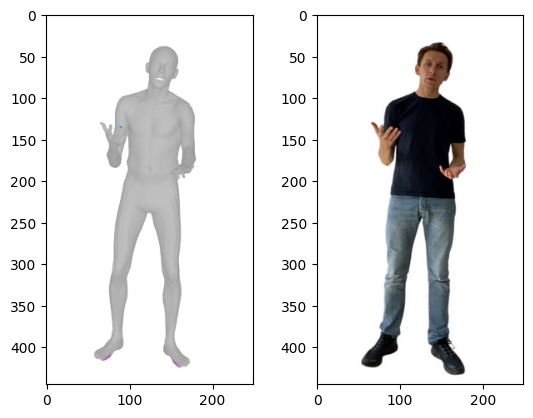

In [29]:
## image
import matplotlib.pyplot as plt
from PIL import Image
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

img1 = Image.open('/content/data/smplifyx_results/rendered_smplifyx_meshes/00000.png')
img2 = Image.open('/content/data/images/man.png')
ax1.imshow(img1)
ax2.imshow(img2)

In [ ]:
## 3D obj
#### Maybe, you can implement below code in your computer.
#!pip install vedo
#from vedo import Mesh

#mesh = Mesh("/content/data/smplifyx_results/meshes/sample/000.obj",)
#mesh.texture("/content/data/images/sample.jpg", scale=0.1)

#mesh.show()
